In [1]:
import os
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4024)])
  except RuntimeError as e:
    print(e)
import tensorflow_probability as tfp

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import imageio
import time
import matplotlib.pyplot as plt
import numpy as np

import PIL.Image

In [2]:
def load_img(img_path):
    #Load image to 512 pixel
    max_dim = 512
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3) #decode to uint8, 3 channels rgb
    img = tf.image.convert_image_dtype(img, tf.float32)  #covert image to float32

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)  #cast tensor to tf.int32

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [3]:
#pick the image and the style
#Original Image + 2 style image
original_img = load_img('C:/Users/Toby/Desktop/CS 698 Final Project/Images/q8.jpg')
style_img = load_img('C:/Users/Toby/Desktop/CS 698 Final Project/Images/pixel_style.png')
style_img_2 = load_img('C:/Users/Toby/Desktop/CS 698 Final Project/Images/mellow.jpg')

In [4]:
#process and resize image
x = tf.keras.applications.vgg19.preprocess_input(original_img*255)
x = tf.image.resize(x, (224, 224))
# vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
# r = vgg(x) #prediction_probabilities
# vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

In [5]:
#Use VGG 19 to do predictions on what the picture actually is 
#Does not need to run for essential functionality
# predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(r.numpy())[0]
# [(class_name, prob) for (number, class_name, prob) in predicted_top_5]

In [6]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    #Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [7]:
#Checking all the layers names in VGG19
# for layer in vgg.layers:
#     print(layer.name)

In [8]:
#Define the VGG layers for original and style layers
original_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

In [9]:
#Grab the number of layers in both original and style layer
num_original_layers = len(original_layers)
num_style_layers = len(style_layers)

In [10]:
#Define extractors to extract style
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_img*255)

It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calcualted for a particular layer as:

In [11]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [12]:
class StyleOriginalModel(tf.keras.models.Model):
    def __init__(self, style_layers, original_layers):
        super(StyleOriginalModel, self).__init__()
        self.vgg = vgg_layers(style_layers + original_layers)
        self.style_layers = style_layers
        self.original_layers = original_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, original_outputs = (outputs[:self.num_style_layers],
                                           outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        original_dict = {original_name: value
                         for original_name, value
                         in zip(self.original_layers, original_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'original': original_dict, 'style': style_dict}

In [13]:
# variant loss fuctions
# hinge Loss
hingLoss = tf.keras.losses.Hinge()
# huber loss
huber = tf.keras.losses.Huber(delta=1.0)
# mean squared error: L2 loss
mse = tf.keras.losses.MeanSquaredError()
# mean absolute error: L1 loss
mae = tf.keras.losses.MeanAbsoluteError()
# binary crossentropy
bce = tf.keras.losses.BinaryCrossentropy()

# 
# def loss_func(y_true, y_pred, lossfunc):
#     return lossfunc(y_true, y_pred)


In [14]:
extractor = StyleOriginalModel(style_layers, original_layers)  #Extract style

results = extractor(tf.constant(original_img))   #Extract original
style_results = results['style']

#Set your style and content target values
style_targets = extractor(style_img)['style']
original_targets = extractor(original_img)['original']
style_targets_2 = extractor(style_img_2)['style']

#Define a tf.Variable to contain the image to optimize. 
#To make this quick, initialize it with the content image 
#(the tf.Variable must be the same shape as the content image):
image = tf.Variable(original_img)

In [15]:
def clip_0_1(image):
    #Since this is a float image, define a function to keep the pixel values between 0 and 1
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)


#To optimize this, use a weighted combination of the two losses to get the total loss
original_weight = 1e3
style_weight = 1e6

def style_original_loss(outputs, lossfunc):
    # Loss function that calculates the loss for both original and style images
    style_outputs = outputs['style']
    original_outputs = outputs['original']
    
    # style loss
    style_loss = tf.add_n([lossfunc(style_outputs[name], style_targets[name])
                           for name in style_outputs.keys()])
    style_loss += tf.add_n([lossfunc(style_outputs[name], style_targets_2[name])
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers * 2
    # content loss 
    original_loss = tf.add_n([lossfunc(original_outputs[name], original_targets[name])
                             for name in original_outputs.keys()])
    original_loss *= original_weight / num_original_layers
    loss = style_loss + original_loss
    return loss

In [16]:
common_learning_rate = 0.01
common_epsilon = 1e-6

# Create an optimizer. The paper recommends LBFGS, but Adam works okay, too
Adam_opt = tf.keras.optimizers.Adam(
    learning_rate=common_learning_rate, beta_1=0.9, beta_2=0.99, epsilon=common_epsilon, amsgrad=False, name='Adam'
)

# Stochastic gradient descent
SGD_opt = tf.keras.optimizers.SGD(
    learning_rate=common_learning_rate, momentum=0.0, nesterov=False, name='SGD'
)

# Adadelta optimizer
Adadelta_opt = tf.keras.optimizers.Adadelta(
    learning_rate=common_learning_rate, rho=0.95, epsilon=common_epsilon, name='Adadelta'
)

# Adagrad optimizer 
Adagrad_opt = tf.keras.optimizers.Adagrad(
    learning_rate=common_learning_rate, initial_accumulator_value=0.1, epsilon=common_epsilon, name='Adagrad'
)

# RMSprop optimizer
RMSprop_opt = tf.keras.optimizers.RMSprop(
    learning_rate=common_learning_rate, rho=0.9, momentum=0.0, epsilon=common_epsilon, centered=False, name='RMSprop'
)

# Ftrl optimizer
Ftrl_opt = tf.keras.optimizers.Ftrl(
    learning_rate=common_learning_rate, learning_rate_power=-0.5, initial_accumulator_value=0.1,
    l1_regularization_strength=0.0, l2_regularization_strength=0.0, name='Ftrl',
    l2_shrinkage_regularization_strength=0.0
)

# Much like Adam is essentially RMSprop with momentum, Nadam is Adam with Nesterov momentum.
Nadam_opt = tf.keras.optimizers.Nadam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=common_epsilon, name='Nadam'
)

In [17]:
#explicit regularization term on the high frequency components of the image
def high_pass_x_y(image):
    x_var = image[:,:,1:,:] - image[:,:,:-1,:]
    y_var = image[:,1:,:,:] - image[:,:-1,:,:]

    return x_var, y_var

x_deltas, y_deltas = high_pass_x_y(original_img)
x_deltas, y_deltas = high_pass_x_y(image)
sobel = tf.image.sobel_edges(original_img)

#The regularization loss associated with this is the sum of the squares of the values
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_mean(x_deltas**2) + tf.reduce_mean(y_deltas**2)

In [18]:
#A hyper parameter to change
total_variation_weight = 1e-2

In [19]:
#Function to show image
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

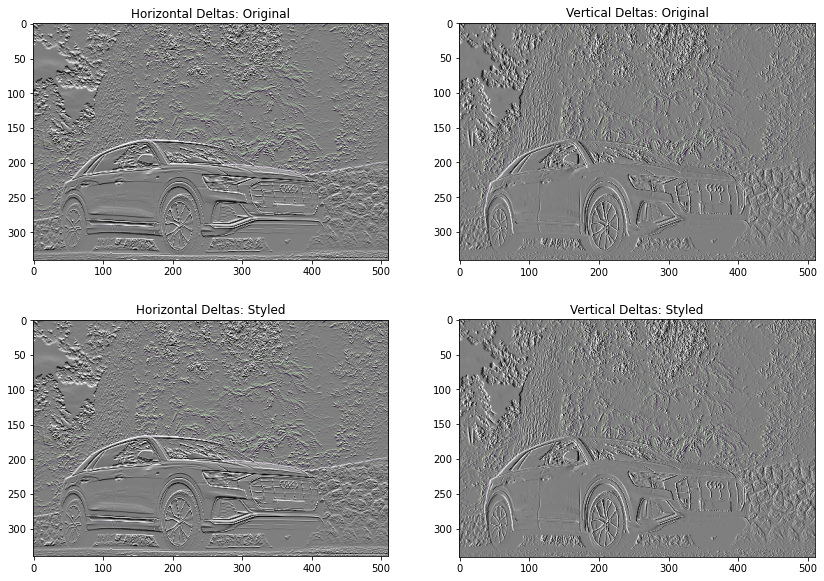

In [20]:
#Functions showing the extracted content and styled content layout
x_deltas, y_deltas = high_pass_x_y(original_img)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

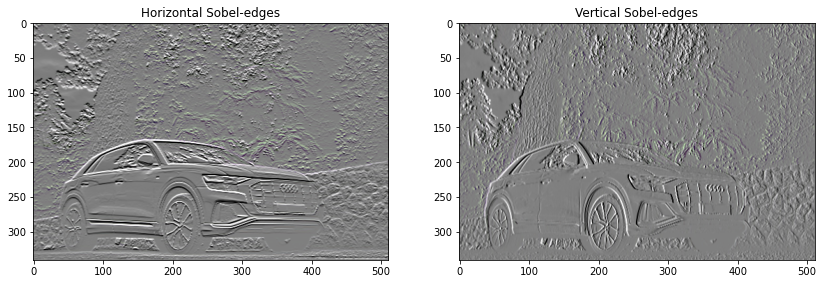

In [21]:
#Sobel Edge
plt.figure(figsize=(14,10))

plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[...,1]/4+0.5), "Vertical Sobel-edges")

In [22]:
def get_train_step():
    #Use tf.GradientTape to update the image.
    @tf.function()
    def train_step(image, opt, lossfunc):
        with tf.GradientTape() as tape:
            outputs = extractor(image)
            loss = style_original_loss(outputs, lossfunc)
            loss += total_variation_weight*total_variation_loss(image)

        grad = tape.gradient(loss, image)
        # optimizer apply here
        opt.apply_gradients([(grad, image)])
        image.assign(clip_0_1(image))
        return loss
    return train_step

In [23]:
# image = tf.Variable(original_img)

In [24]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [25]:
def train_results(opt, opt_name, lossfunc, lossfunc_name):
    ''' train image with specified optimizer and loss function
        training interations = epochs * steps_per_epoch
    Args:
        opt: The optimizer to use.
        opt_name: The optimizer name
        lossfunc: The loss function to use
        lossfunc_name: The loss function name
    Return:
        wat: The waiting time list
        los: The loss value list
    '''
    # epochs to take 
    epochs = 10
    # steps in each  epoch 
    steps_per_epoch = 50
    
    # image instance of original image
    image = tf.Variable(original_img)
    
    losses = []
    
    start_time = time.time()
    
    for n in range(epochs):
        print("epoch - ", n)
    #     imageio.imwrite("images/cat_precedure_epoch{}.jpg".format(n), image[0])
        for m in range(steps_per_epoch):
#             print("step - ", m)
            train_step = get_train_step()
            tloss = train_step(image, opt, lossfunc)
            wall_time = time.time() - start_time
            # append wall time , total loss 
            losses.append((wall_time, tloss))
    
    loss_arr = np.asarray(losses)
    wat = loss_arr[:, 0]
    los = loss_arr[:, 1]
    
    
    # 
    file_name = 'C:/Users/Toby/Desktop/CS 698 Final Project/Images/results/q8_transfered_' + opt_name + '_' + lossfunc_name + '.jpg'
    tensor_to_image(image).save(file_name)

    return wat, los

In [26]:
optimizers = [Adam_opt, Adagrad_opt, Adadelta_opt, RMSprop_opt, Ftrl_opt, Nadam_opt]
labels = ['Adam', "Adagrad", "Adadelta", "RMS", "Ftrl", "Nadam"]
lossfuncList = []
lossfuncNameList = []

# waiting time list
wtl = []
# total lost list
lvl = []

for i in range(len(optimizers)):
    print("========Optimizer - ", optimizers[i], "==========")
    # get waiting time , loss value pair
#     wt, lv = train_results(optimizers[i], labels[i], mse, "MSE")
    wt, lv = train_results(optimizers[i], labels[i], mse, "MSE")
    wtl.append(wt)
    lvl.append(lv)

========Optimizer -  <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x000001ECC1B88AC8> ==========
epoch -  0
epoch -  1
epoch -  2
epoch -  3
epoch -  4
epoch -  5
epoch -  6
epoch -  7
epoch -  8
epoch -  9
========Optimizer -  <tensorflow.python.keras.optimizer_v2.adagrad.Adagrad object at 0x000001ECC1B88B88> ==========
epoch -  0
epoch -  1
epoch -  2
epoch -  3
epoch -  4
epoch -  5
epoch -  6
epoch -  7
epoch -  8
epoch -  9
========Optimizer -  <tensorflow.python.keras.optimizer_v2.adadelta.Adadelta object at 0x000001ECC1B88B08> ==========
epoch -  0
epoch -  1
epoch -  2
epoch -  3
epoch -  4
epoch -  5
epoch -  6
epoch -  7
epoch -  8
epoch -  9
========Optimizer -  <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x000001ECC1B88C08> ==========
epoch -  0
epoch -  1
epoch -  2
epoch -  3
epoch -  4
epoch -  5
epoch -  6
epoch -  7
epoch -  8
epoch -  9
========Optimizer -  <tensorflow.python.keras.optimizer_v2.ftrl.Ftrl object at 0x000001ECC1B88C48> =

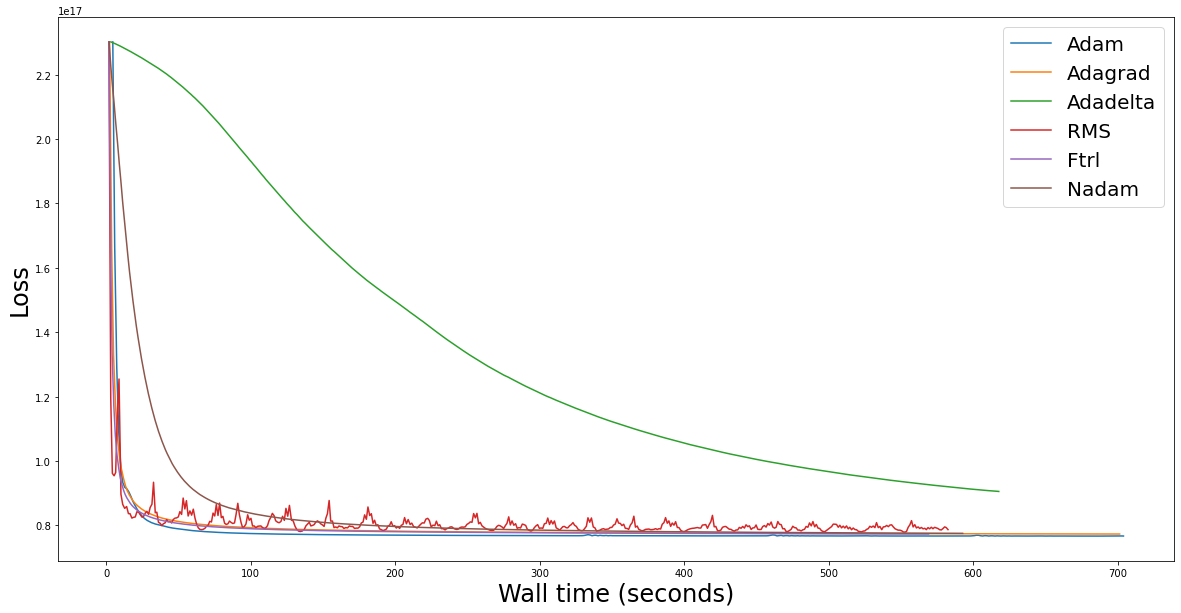

In [27]:
fig = plt.figure(9, figsize=(20, 10))

for i in range(len(wtl)):
    plt.plot(wtl[i], lvl[i], label=labels[i])

plt.legend(loc='upper right', fontsize=20)
plt.xlabel('Wall time (seconds)', fontsize=24)
plt.ylabel('Loss', fontsize=24)
# plt.ylim([0, 1e+8])
plt.show()